In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Data file paths:
train_data_json = '/content/drive/MyDrive/Datasets/train.json'
dev_data_json = '/content/drive/MyDrive/Datasets/dev.json'
train_data_csv = '/content/drive/MyDrive/Datasets/train_data_converted_json_to_csv1_0.csv'
dev_data_csv = '/content/drive/MyDrive/Datasets/dev_data_converted_json_to_csv.csv'

In [3]:
import pandas as pd
import numpy as np
import re
import json
import csv
import nltk
import string
import torch
import math
from sklearn import svm
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import Counter
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [5]:
#Code to convert given train data from json to csv
f = open (train_data_json, "r")
data1 = json.loads(f.read())
 
data_file = open(train_data_csv, 'w', newline='')
csv_writer = csv.writer(data_file)

count = 0
for item in data1:
    for data_item in item['annotations']:
        for result_item in data_item['result']:
          if count == 0:
            header = result_item['value'].keys()
            csv_writer.writerow(header)
            count += 1
          csv_writer.writerow(result_item['value'].values())

In [6]:
#Code to convert given dev data from json to csv
f = open (dev_data_json, "r")
data1 = json.loads(f.read())
 
data_file = open(dev_data_csv, 'w', newline='')
csv_writer = csv.writer(data_file)

count = 0
for item in data1:
    for data_item in item['annotations']:
        for result_item in data_item['result']:
          if count == 0:
            header = result_item['value'].keys()
            csv_writer.writerow(header)
            count += 1
          csv_writer.writerow(result_item['value'].values())

In [7]:
data_legal = pd.read_csv(train_data_csv)
data_legal

,start,end,text,labels
0,0,116,"IN THE HIGH COURT OF KARNATAKA,\n ...",['PREAMBLE']
1,116,678,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,['PREAMBLE']
2,678,964,This Criminal Appeal is filed under Section 37...,['PREAMBLE']
3,964,1093,\n\n This appeal coming on for hearing t...,['PREAMBLE']
4,1093,1180,\n Heard the learned Counsel for the app...,['NONE']
...,...,...,...,...
28981,21494,21601,\n So Section 132 of the Evidence Act sufficie...,['RATIO']
28982,21601,21652,"\n For the reasons aforesaid, the appeal is al...",['RPC']
28983,21653,21761,"The judgment and order dated April 27, 1987 pa...",['RPC']
28984,21761,21769,\n R.S.S.,['NONE']


{"['ANALYSIS']": 10695, "['FAC']": 5744, "['PREAMBLE']": 4167, "['PRE_RELIED']": 1431, "['NONE']": 1423, "['ARG_PETITIONER']": 1315, "['RPC']": 1081, "['RLC']": 752, "['ARG_RESPONDENT']": 698, "['RATIO']": 674, "['STA']": 481, "['ISSUE']": 367, "['PRE_NOT_RELIED']": 158}


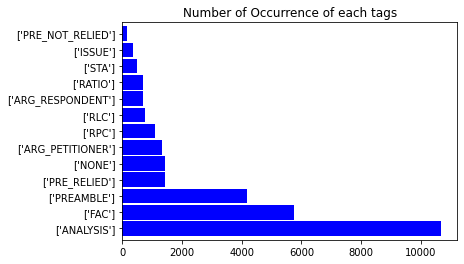

In [8]:
labels_print = data_legal['labels']
labels_print_count = labels_print.explode().value_counts()
print(dict(labels_print_count))
labels_print_count.plot(kind="barh", width=0.9, color="blue", title="Number of Occurrence of each tags")
plt.savefig('/content/drive/MyDrive/NLP_Assignments/NLP_243/Legal_Eval/labels_frequency_new.png',)

In [9]:
#Code of data preprocessing
stop_words = stopwords.words('english')
def preprocess(data_df):
  data_df['text'] = data_df['text'].apply(lambda t: t.lower()) #Convert to lower
  data_df['text'] = data_df['text'].apply(lambda t: re.sub("\n", ' ', t)) #Remove new line
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'\.{2,}','.', t)) #regular expression for normalizing repeated ... patterns
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'[\"\"#\$%&\(\)\*\+,-/:;<=>\@\[\\\]\^_`{\|}~]', ' ', t)) #remove punctuations
  data_df['text'] = data_df['text'].apply(lambda t: re.sub('"', '', t)) #remove redundant ' " '
  data_df['text'] = data_df['text'].str.replace('\d+', '') #remove numbers
  data_df['text'] = data_df['text'].str.strip() #remove extra spaces
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join(t.strip().split()))
  data_df['labels'] = data_df['labels'].str.replace(r'[\[\]\'\']', '') #remove punctuations from labels
  data_df['text'] = data_df['text'].str.replace(' +$', '') #remove extra spaces at end
  data_df['labels'] = data_df['labels'].apply(lambda t: t.lower()) #convert to lower of labels
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join([t for t in nltk.word_tokenize(t) if t.lower() not in stop_words])) #removal of stop words and tokenization
  return data_df

In [10]:
preprocess(data_legal)

<ipython-input-9-e23a4753132c>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['text'] = data_df['text'].str.replace('\d+', '') #remove numbers
<ipython-input-9-e23a4753132c>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['labels'] = data_df['labels'].str.replace(r'[\[\]\'\']', '') #remove punctuations from labels
<ipython-input-9-e23a4753132c>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['text'] = data_df['text'].str.replace(' +$', '') #remove extra spaces at end


,start,end,text,labels
0,0,116,high court karnataka circuit bench gulbarga da...,preamble
1,116,678,hon'ble mr justice anand byrareddy criminal ap...,preamble
2,678,964,criminal appeal filed section code criminal pr...,preamble
3,964,1093,appeal coming hearing day court delivered foll...,preamble
4,1093,1180,heard learned counsel appellant learned govern...,none
...,...,...,...,...
28981,21494,21601,section evidence act sufficiently protects sin...,ratio
28982,21601,21652,reasons aforesaid appeal allowed,rpc
28983,21653,21761,judgment order dated april passed revision pet...,rpc
28984,21761,21769,r,none


In [11]:
#Code to remove empty rows after pre processing
count_rows = data_legal.shape[0]
print(count_rows)

28986


In [12]:
data_legal['text'].replace('', np.nan, inplace=True)
data_legal['text'].isna().sum()

422

In [13]:
data_legal = data_legal.dropna(subset=['text'])

In [14]:
count_rows = data_legal.shape[0]
print(count_rows)

28564


In [15]:
#Code to sample data
df = data_legal[data_legal['labels'] != 'analysis']

In [16]:
df2 = df[df['labels'] != 'preamble']

In [17]:
df3 = df2[df2['labels'] != 'fac']

In [18]:
new_df1 = data_legal[data_legal.labels == 'analysis'].sample(1600)
new_df2 = data_legal[data_legal.labels == 'preamble'].sample(1600)
new_df3 = data_legal[data_legal.labels == 'fac'].sample(1600)

In [19]:
frames = [new_df1, new_df2, new_df3, df3]

In [20]:
res = pd.concat(frames)

In [21]:
res

,start,end,text,labels
20523,14226,14338,evidence p w appears resides village juradanga...,analysis
849,26539,26610,case section need prior meeting minds,analysis
6254,32458,32661,observation incorrect ample material record sh...,analysis
9637,20207,20500,would first deal decision allahabad high court...,analysis
22686,30576,30712,evidence record clearly shows item suit schedu...,analysis
...,...,...,...,...
28981,21494,21601,section evidence act sufficiently protects sin...,ratio
28982,21601,21652,reasons aforesaid appeal allowed,rpc
28983,21653,21761,judgment order dated april passed revision pet...,rpc
28984,21761,21769,r,none


In [22]:
data_legal = res
data_legal

,start,end,text,labels
20523,14226,14338,evidence p w appears resides village juradanga...,analysis
849,26539,26610,case section need prior meeting minds,analysis
6254,32458,32661,observation incorrect ample material record sh...,analysis
9637,20207,20500,would first deal decision allahabad high court...,analysis
22686,30576,30712,evidence record clearly shows item suit schedu...,analysis
...,...,...,...,...
28981,21494,21601,section evidence act sufficiently protects sin...,ratio
28982,21601,21652,reasons aforesaid appeal allowed,rpc
28983,21653,21761,judgment order dated april passed revision pet...,rpc
28984,21761,21769,r,none


In [23]:
test_legal = pd.read_csv(dev_data_csv)
test_legal.head()

,start,end,text,labels
0,0,95,PETITIONER:\nTHE COMMISSIONER OF INCOME-TAXNEW...,['PREAMBLE']
1,95,143,\n\nDATE OF JUDGMENT:\n05/05/1961\n\nBENCH:\nD...,['PREAMBLE']
2,143,581,"\nBENCH:\nDAS, S.K.\nHIDAYATULLAH, M.\nSHAH, J...",['PREAMBLE']
3,582,774,It\nentered into transactions in the nature of...,['PREAMBLE']
4,775,855,The assessee claimed deduction of these\nlosse...,['PREAMBLE']


In [24]:
preprocess(test_legal)

<ipython-input-9-e23a4753132c>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['text'] = data_df['text'].str.replace('\d+', '') #remove numbers
<ipython-input-9-e23a4753132c>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['labels'] = data_df['labels'].str.replace(r'[\[\]\'\']', '') #remove punctuations from labels
<ipython-input-9-e23a4753132c>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df['text'] = data_df['text'].str.replace(' +$', '') #remove extra spaces at end


,start,end,text,labels
0,0,95,petitioner commissioner income taxnew delhi vs...,preamble
1,95,143,date judgment bench das k,preamble
2,143,581,bench das k hidayatullah shah j c citation scr...,preamble
3,582,774,entered transactions nature forward transactio...,preamble
4,775,855,assessee claimed deduction losses computation ...,preamble
...,...,...,...,...
2837,4734,5055,though p w doctor case deposed dated pm examin...,fac
2838,5055,5217,learned counsel appearing behalf accused also ...,arg_respondent
2839,5218,5276,accused persons entitled clean acquittal,arg_respondent
2840,5276,5444,case hand witnesses examined behalf prosecutio...,analysis


In [25]:
#Code to remove empty rows in test data
count_rows = test_legal.shape[0]
print(count_rows)

2842


In [26]:
test_legal['text'].replace('', np.nan, inplace=True)
test_legal['text'].isna().sum()

32

In [27]:
test_legal = test_legal.dropna(subset=['text'])

In [28]:
count_rows = test_legal.shape[0]
print(count_rows)

2810


{'court': 3114, 'section': 1990, 'case': 1773, 'accused': 1697, 'act': 1630, 'p': 1496, 'tax': 1278, 'order': 1146, 'income': 1076, 'appellant': 941, 'high': 933, 'appeal': 904, 'c': 891, 'evidence': 886, 'state': 876, 'learned': 866, 'also': 803, 'v': 802, 'judgment': 794, 'assessee': 767, 'petitioner': 766, 'respondent': 688, 'said': 664, 'would': 657, 'w': 649, 'pw': 644, 'offence': 630, 'made': 627, 'r': 623, 'may': 622, 'prosecution': 604, 'whether': 595, 'shall': 581, 'b': 544, 'law': 541, 'counsel': 541, 'dated': 524, 'held': 518, 'j': 516, 'judge': 503, 'trial': 497, 'therefore': 494, 'criminal': 485, 'officer': 478, 'one': 478, "'": 475, 'question': 471, 'view': 460, 'years': 442, 'assessment': 434, 'rs': 429, 'filed': 427, 'ltd': 426, 'commissioner': 410, 'ext': 399, 'time': 398, 'person': 386, 'facts': 364, 'mr': 359, 'code': 359, 'tribunal': 355, 'india': 353, 'year': 352, 'submitted': 348, 'circumstances': 340, 'vs': 336, 'company': 334, 'police': 331, 'upon': 324, 'ex': 3

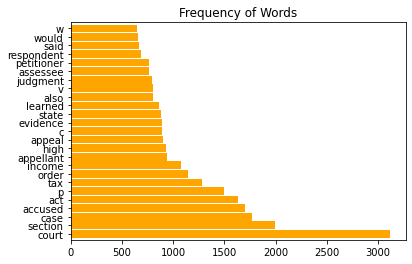

In [29]:
#Code to print the frequency of words in the data
words = data_legal['text'].str.split(" ")
words_count = words.explode().value_counts()
print(dict(words_count))
words_count[:25].plot(kind="barh", width=0.9, color="orange", title="Frequency of Words")
plt.savefig('/content/drive/MyDrive/NLP_Assignments/NLP_243/Legal_Eval/words_frequency_new.png',)

{'analysis': 1600, 'preamble': 1600, 'fac': 1600, 'pre_relied': 1425, 'none': 1373, 'arg_petitioner': 1302, 'rpc': 1076, 'rlc': 745, 'arg_respondent': 694, 'ratio': 673, 'sta': 472, 'issue': 362, 'pre_not_relied': 158}


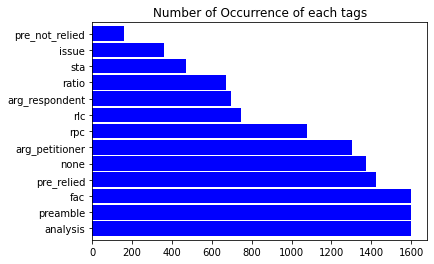

In [30]:
#Code to print the frequency distribution of labels after sampling
labels_print = data_legal['labels']
labels_print_count = labels_print.explode().value_counts()
print(dict(labels_print_count))
labels_print_count.plot(kind="barh", width=0.9, color="blue", title="Number of Occurrence of each tags")
plt.savefig('/content/drive/MyDrive/NLP_Assignments/NLP_243/Legal_Eval/labels_frequency_new.png',)

In [ ]:
#Code to build vocabulary on the data
vocab=[]
for i in data_legal['text']:
  for j in i.split(" "):
    vocab.append(j)
vocab=set(vocab)
vocab1=list(vocab)
vocab2=['<unk>']

vocab2.extend(vocab1) 
vocab=vocab2
vocab_size = len(vocab)
print(vocab)
print(vocab_size)

['<unk>', 'accounts', 'closure', 'differences', 'adjoin', 'enterprises', 'hegde', 'teak', 'intercourse', "'education", 'chirag', 'refund', 'jurors', 'argument', 'failed', 'evidently', 'busy', 'parikhita', 'moreover', 'dalwai', 'delivering', 'aiming', 'seize', 'responsible', 'depilatories', 'untrusty', 'jutz', 'concealed', 'gudia', 'ɬaz', 'beats', 'sahai', 'menon', 'privileges', 'urgent', 'godsay', 'girth', 'khairnar', 'concurs', 'andhra', 'lows', 'pleading', 'hobshaw', 'group', 'questioned', 'packed', 'floor', 'rathi', 'assistant', 'aruna', 'rm', 'improbability', 'canal', 'french', 'rules', 'glossaries', 'graver', 'punisha', 'cropped', 'promote', 'accross', 'intentionally', 'postmaster', 'khatod', 'knowing', 'conjecture', 'privilege', 'snacks', 'stomach', 'strictly', 'mahazar', 'govinda', 'wash', 'toning', 'palace', 'leveled', 'rising', 'unnatural', 'cycle', 'well', 'leases', 'bhatt', 'litigations', 'magnitude', 'rangaiah', 'thefts', 'prejudice', 'hingni', 'grudge', 'patients', 'reques

In [ ]:
text2id = {text: i for i, text in enumerate(vocab)}
id2text={i:text for text,i in text2id.items()}

In [ ]:
#Code to build a list of labels
labels=[]
for i in data_legal['labels']:
  for j in i.split(" "):
    labels.append(j)
labels=set(labels)
labels=list(labels)
labels_size = len(labels)
print(labels)
print(labels_size)

['ratio', 'pre_not_relied', 'issue', 'sta', 'none', 'rlc', 'arg_respondent', 'fac', 'preamble', 'arg_petitioner', 'analysis', 'rpc', 'pre_relied']
13


In [ ]:
label2id = {tag: i for i, tag in enumerate(labels)}
id2label={i:tag for tag,i in label2id.items()}

In [ ]:
#Code of dataset class
class ModelDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def one_hot_encode_labels(self, label: List[str]):
    onehot_label_encoded = [0 for _ in range(len(labels))]
    for i in range(len(label)):
      onehot_label_encoded[label2id[label[i]]] = 1 
    return onehot_label_encoded
  
  def encode_tokens(self, tokens):
    token_encoded = []
    for text in tokens.split():
      if text in text2id:
        token_encoded.append(text2id[text])
      else:
        token_encoded.append(text2id['<unk>'])
    encoded = [0 for _ in range(vocab_size)]
    for value in token_encoded:
      encoded[value] = 1
    return encoded
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, n: int):
    input = self.data['text'].iloc[n]
    output = self.data['labels'].iloc[n]
    var1 = torch.tensor(self.encode_tokens(input)).to(torch.float)
    var2 = torch.tensor(self.one_hot_encode_labels([output])).to(torch.float)
    return var1, var2

In [ ]:
#Code to build the datasets
train_dataset = ModelDataset(data_legal)
test_dataset = ModelDataset(test_legal)

In [ ]:
#Code to build data loader of train and test
train_loader = DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)

In [ ]:
#Main code of model
class MLP(torch.nn.Module):
  def __init__(self, input_size, output_size):
      super(MLP, self).__init__()
      self.input_size = input_size
      self.output_size = output_size
      self.fc1 = torch.nn.Linear(self.input_size, 400)
      self.h1 = torch.nn.Linear(400, 200)
      self.h2 = torch.nn.Linear(200, 100)
      self.droput1 = torch.nn.Dropout(0.2)
      self.relu = torch.nn.ReLU()
      self.tanh = torch.nn.Tanh()
      self.fc2 = torch.nn.Linear(100, self.output_size)
      self.droput2 = torch.nn.Dropout(0.3)
      self.sigmoid = torch.nn.Sigmoid()
  def forward(self, x):

      #MLP with two hidden layers with dropout
      x1 = self.relu(self.fc1(x))
      h1 = self.relu(self.droput1(self.h1(x1)))
      h2 = self.relu(self.droput2(self.h2(h1)))
      output = self.fc2(h2)

      return output

In [ ]:
model = MLP(vocab_size, labels_size).to(device)

In [ ]:
#Code to train the model
def train(loader, model, optimizer, loss_fn):
  model.train()
  losses = []
  total_tags=0
  epoch_acc=0
  pbar = tqdm(loader)
  for x, y in pbar:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()

    logits = model(x)
    loss = loss_fn(logits, torch.tensor(y).to(torch.float))
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())

    y_pred = (logits).to('cpu').detach().numpy()
    y_pred=(np.array(y_pred) >= 0)*1
    y_0=y.to('cpu').detach().numpy()
    val_acc = sum([(y_0[i]==y_pred[i]).all()*1 for i in range(len(y_0))])
    epoch_acc+=val_acc
    total_tags+=len(y)

    loss.backward()  # Calculates gradients for weights /bais
    optimizer.step()  # Updates weights according to optimizer
  acc = round(epoch_acc/total_tags,3)
  return sum(losses) / len(losses), acc


#Code to evaluate the model
def evaluate(loader, model, loss_fn):
  model.eval()
  predictions = []
  labels = []
  losses = []
  val_epoch_acc=0
  total_val_tags=0
  val_acc_list = []
  for x, y in tqdm(loader):
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    loss = loss_fn(logits, torch.tensor(y).to(torch.float))

    y_pred = (logits).to('cpu').detach().numpy()
    y_pred=(np.array(y_pred) >= 0)*1
    y_0=y.to('cpu').detach().numpy()
    val_acc = sum([(y_0[i]==y_pred[i]).all()*1 for i in range(len(y_0))])
    val_epoch_acc+=val_acc
    total_val_tags+=len(y)

    labels.append(y.cpu().numpy())
    losses.append(loss.item())
  avg_loss=sum(losses)/len(losses)
  acc=round(val_epoch_acc/total_val_tags,3)
  val_acc_list.append(acc)
  return avg_loss, acc

In [ ]:
#Code to train the model based on epochs
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.BCEWithLogitsLoss()
score_fn = accuracy_score
n_epochs = 5
best_acc = 0
losses = []
val_losses = []
train_acc= []
val_acc = []
for epoch in range(n_epochs):
  avg_loss, acc_train = train(train_loader, model, optimizer, loss_fn)
  print('epoch:', epoch, 'train loss: ', avg_loss)
  print('train acc:', acc_train)
  losses.append(avg_loss)
  train_acc.append(acc_train)
  val_loss, accu = evaluate(test_loader, model, loss_fn)
  print('val loss: ', val_loss)
  print('val acc: ', accu)
  val_losses.append(val_loss)
  val_acc.append(accu)

  0%|          | 0/204 [00:00<?, ?it/s]<ipython-input-39-65e0e635502d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(logits, torch.tensor(y).to(torch.float))
100%|██████████| 204/204 [00:19<00:00, 10.54it/s, loss=0.203]


epoch: 0 train loss:  0.243386846766168
train acc: 0.104


  0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-39-65e0e635502d>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(logits, torch.tensor(y).to(torch.float))
100%|██████████| 44/44 [00:03<00:00, 11.78it/s]


val loss:  0.1992160522124984
val acc:  0.168


100%|██████████| 204/204 [00:20<00:00,  9.93it/s, loss=0.169]


epoch: 1 train loss:  0.1607079004467118
train acc: 0.405


100%|██████████| 44/44 [00:03<00:00, 11.74it/s]


val loss:  0.1856486929411238
val acc:  0.231


100%|██████████| 204/204 [00:20<00:00, 10.15it/s, loss=0.098]


epoch: 2 train loss:  0.11006346929307077
train acc: 0.615


100%|██████████| 44/44 [00:03<00:00, 11.88it/s]


val loss:  0.20805395292964848
val acc:  0.311


100%|██████████| 204/204 [00:18<00:00, 11.12it/s, loss=0.0704]


epoch: 3 train loss:  0.07571911448430196
train acc: 0.759


100%|██████████| 44/44 [00:03<00:00, 11.86it/s]


val loss:  0.23709134147925812
val acc:  0.33


100%|██████████| 204/204 [00:18<00:00, 11.07it/s, loss=0.0678]


epoch: 4 train loss:  0.0565402051525227
train acc: 0.833


100%|██████████| 44/44 [00:03<00:00, 11.96it/s]

val loss:  0.2651622637429021
val acc:  0.341


[0.243386846766168, 0.1607079004467118, 0.11006346929307077, 0.07571911448430196, 0.0565402051525227]
[0.1992160522124984, 0.1856486929411238, 0.20805395292964848, 0.23709134147925812, 0.2651622637429021]


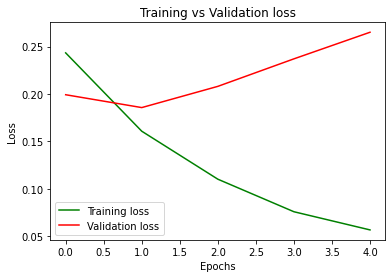

In [ ]:
#Code to plot loss graph of train vs val
plt.plot(range(n_epochs), losses, 'g', label='Training loss')
print(losses)
plt.plot(range(n_epochs), val_losses, 'r', label='Validation loss')
print(val_losses)
plt.title('Training vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.104, 0.405, 0.615, 0.759, 0.833]
[0.168, 0.231, 0.311, 0.33, 0.341]


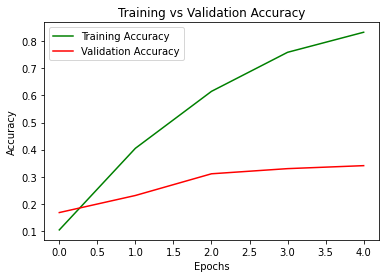

In [ ]:
#Code to plot accuracy graph of train vs val
plt.plot(range(n_epochs), train_acc, 'g', label='Training Accuracy')
print(train_acc)
plt.plot(range(n_epochs), val_acc, 'r', label='Validation Accuracy')
print(val_acc)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Code to predict the test values
all_pred=[]
preds = []
for item in test_legal['text'].values:
  encoded_text = test_dataset.encode_tokens(item)
  encoded_text = torch.tensor(encoded_text).to(torch.float).to(device)
  logits = model(encoded_text)
  y_pred = (logits).cpu().detach().numpy()
  y_pred=(np.array(y_pred) >= 0.5)*1
  label = [id2label[_x] for _x in range(len(y_pred)) if y_pred[_x]]
  all_pred.append(" ".join(label))

In [ ]:
class_true = test_legal['labels'].values.tolist()
class_pred = all_pred

In [ ]:
print(classification_report(class_true, class_pred))

                precision    recall  f1-score   support

                     0.00      0.00      0.00         0
      analysis       0.59      0.19      0.28       969
arg_petitioner       0.06      0.03      0.04        66
arg_respondent       0.11      0.29      0.16        35
           fac       0.58      0.27      0.37       575
  fac preamble       0.00      0.00      0.00         0
         issue       0.65      0.77      0.70        48
          none       0.69      0.82      0.75       176
      none fac       0.00      0.00      0.00         0
 none preamble       0.00      0.00      0.00         0
      none rpc       0.00      0.00      0.00         0
pre_not_relied       0.00      0.00      0.00        12
    pre_relied       0.33      0.22      0.26       140
      preamble       0.68      0.46      0.55       493
         ratio       0.22      0.12      0.15        69
           rlc       0.23      0.08      0.12       116
           rpc       0.75      0.64      0.69  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

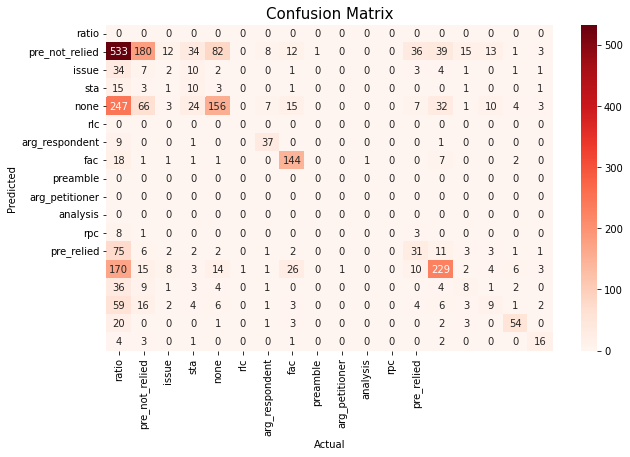

In [ ]:
#Code to get confusion matrix
matrix = confusion_matrix(class_true,class_pred)
plt.figure(figsize=(10,6))
sns.heatmap(matrix, cmap=plt.cm.Reds, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Actual', fontsize=10)
plt.ylabel('Predicted', fontsize=10)
plt.show()